(monitor)=

# Saving & monitoring progress

It is often useful to incrementally save the state of the chain to a file.
This makes it easier to monitor the chain’s progress and it makes things a little less disastrous if your code/computer crashes somewhere in the middle of an expensive MCMC run.

In this demo, we will demonstrate how you can use the new {class}`backends.HDFBackend` to save your results to a [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) file as the chain runs.
To execute this, you'll first need to install the [h5py library](http://www.h5py.org).

We'll also monitor the autocorrelation time at regular intervals (see {ref}`autocorr`) to judge convergence.

In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

We will set up the problem as usual with one small change:

In [2]:
import emcee
import numpy as np

np.random.seed(42)


# The definition of the log probability function
# We'll also use the "blobs" feature to track the "log prior" for each step
def log_prob(theta):
    log_prior = -0.5 * np.sum((theta - 1.0) ** 2 / 100.0)
    log_prob = -0.5 * np.sum(theta**2) + log_prior
    return log_prob, log_prior


# Initialize the walkers
coords = np.random.randn(32, 5)
nwalkers, ndim = coords.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, backend=backend)

The difference here was the addition of a "backend".
This choice will save the samples to a file called `tutorial.h5` in the current directory.
Now, we'll run the chain for up to 10,000 steps and check the autocorrelation time every 100 steps.
If the chain is longer than 100 times the estimated autocorrelation time and if this estimate changed by less than 1%, we'll consider things converged.

In [3]:
max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

  6%|▌         | 5900/100000 [00:55<14:41, 106.81it/s]


Now let's take a look at how the autocorrelation time estimate (averaged across dimensions) changed over the course of this run.
In this plot, the $\tau$ estimate is plotted (in blue) as a function of chain length and, for comparison, the $N > 100\,\tau$ threshold is plotted as a dashed line.

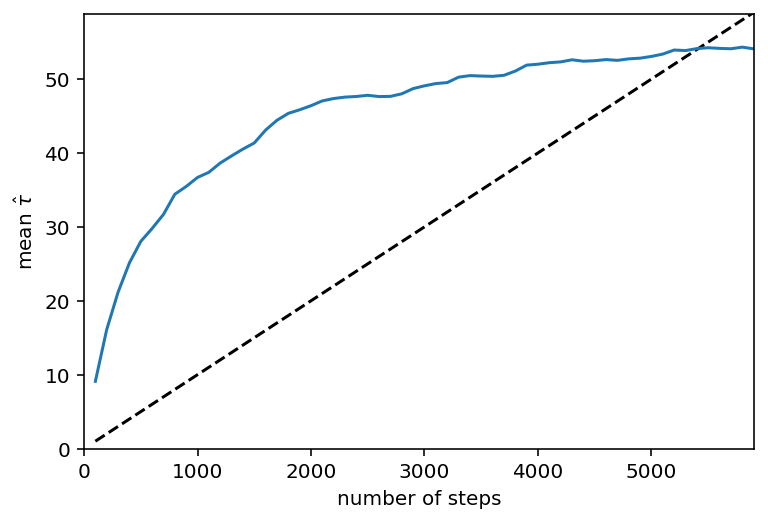

In [4]:
import matplotlib.pyplot as plt

n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

As usual, we can also access all the properties of the chain:

burn-in: 117
thin: 24
flat chain shape: (7680, 5)
flat log prob shape: (7680,)
flat log prior shape: (7680,)


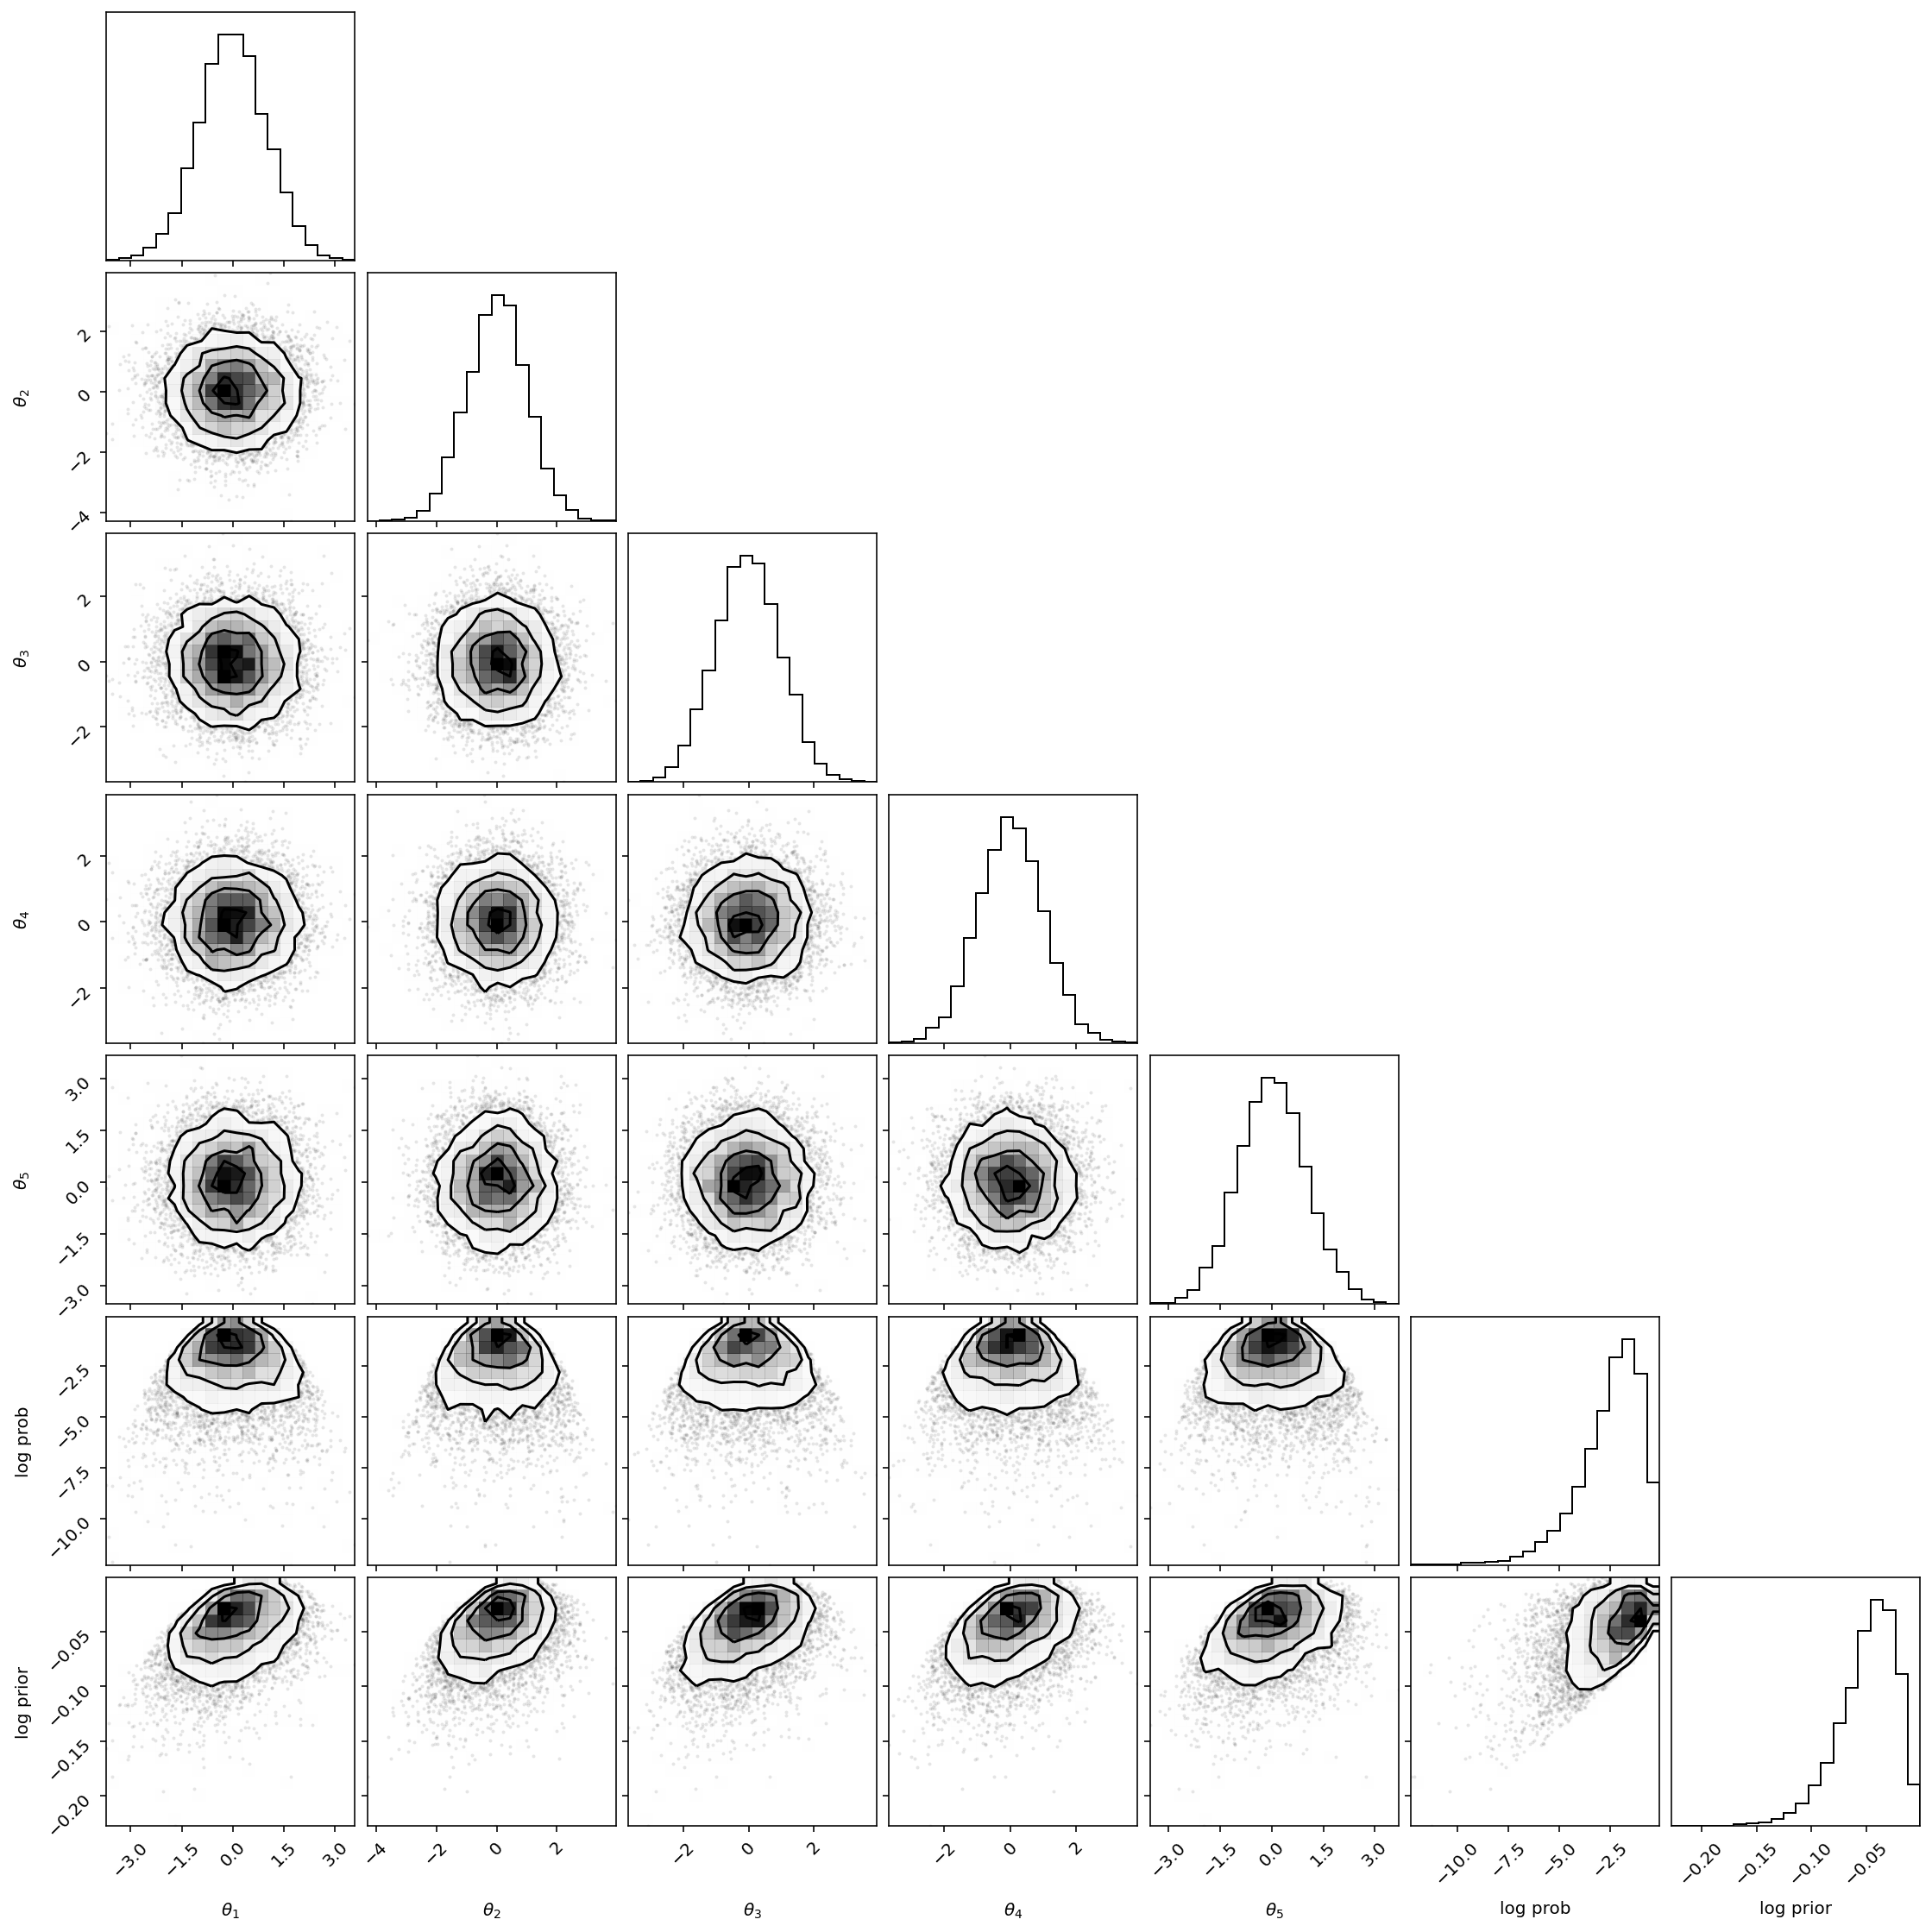

In [5]:
import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)

labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
labels += ["log prob", "log prior"]

corner.corner(all_samples, labels=labels);

But, since you saved your samples to a file, you can also open them after the fact using the {class}`backends.HDFBackend`:

In [6]:
reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

burn-in: 117
thin: 24
flat chain shape: (7680, 5)
flat log prob shape: (7680,)
flat log prior shape: (7680,)


This should give the same output as the previous code block, but you'll notice that there was no reference to `sampler` here at all.

If you want to restart from the last sample, you can just leave out the call to {func}`backends.HDFBackend.reset`:

In [7]:
new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))
new_sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, backend=new_backend
)
new_sampler.run_mcmc(None, 100)
print("Final size: {0}".format(new_backend.iteration))

Initial size: 5900
Final size: 6000


If you want to save *additional* ``emcee`` runs, you can do so on the same file
as long as you set the ``name`` of the backend object to something other than
the default:

In [8]:
run2_backend = emcee.backends.HDFBackend(filename, name="mcmc_second_prior")


# this time, with a subtly different prior
def log_prob2(theta):
    log_prior = -0.5 * np.sum((theta - 2.0) ** 2 / 100.0)
    log_prob = -0.5 * np.sum(theta**2) + log_prior
    return log_prob, log_prior


# Rinse, Wash, and Repeat as above
coords = np.random.randn(32, 5)
nwalkers, ndim = coords.shape
sampler2 = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob2, backend=run2_backend
)

# note: this is *not* necessarily the right number of iterations for this
# new prior.  But it will suffice  to demonstrate the second backend.
sampler2.run_mcmc(coords, new_backend.iteration, progress=True);

100%|██████████| 6000/6000 [00:42<00:00, 139.66it/s]


And now you can see *both* runs are in the file:

In [9]:
import h5py

with h5py.File(filename, "r") as f:
    print(list(f.keys()))

['mcmc', 'mcmc_second_prior']
